# **Facial Expression Recognition, and computing Valence and Arousal**

####*Submitted by:* 
>> **_Usama Aleem Shami_**\
>> _Reg. No. : **329894**\
>> MSCS 2020_
####*Submitted to:* 
>> **_Dr. Muhammad Moazam Fraz_**\
>> _Advanced Computer Vision (CS-893)_

## Table of Contents

1. [Connecting Google Drive and Importing Data Set](#Gdrive)
2. [Importing Packages/Modules](#Package)
3. [GPU Details](#GPU)
4. [Defining Utility Functions](#Func)
5. [Extracting Train and Test .tar files](#Tar)
6. [Reading Images and Annotations](#Anno)
7. [Training Models](#Train)
  * [VGG16](#VGG)
      * [Plots](#plot1)
      * [Model Architecture](#img1)
  * [ResNet50](#ResNet)
      * [Plots](#plot2)
      * [Model Architecture](#img2)
8. [Model Predictions](#Test)
      * [VGG16](#vgg_predict)
      * [ResNet50](#resnet_predict)
9. [Plotting Confusion Matrices and Computing Performance Metrics](#CFM)
      * [VGG16](#vgg_cfm)
      * [ResNet50](#resnet_cfm)
10. [Displaying Qualititative Results](#Qual)
      * [VGG16](#vgg_img)
      * [ResNet50](#resnet_img)

# Connecting Google Drive and Importing Data Set <a name="Gdrive"></a>

In [1]:
# Mounting Google Drive with Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Specifying Google Drive Path where Dataset is located
DATASET_PATH_GDRIVE = '/content/drive/MyDrive/ACV/Assignments/Asg2'

# Specifying Google Colab Path where Dataset is to be copied
DATASET_PATH_LOCAL = '/content/dataset'

In [3]:
# Creating desired Directory in Google Colab WorkSpace
!mkdir $DATASET_PATH_LOCAL

# Copying .tar files from Google Drive to Google Colab WorkSpace
!cp $DATASET_PATH_GDRIVE/*.tar $DATASET_PATH_LOCAL # MUST mention the FILE NAME after GDrive Path

print ("Files Copied to Colab Workspace from GDrive, successfully!")

Files Copied to Colab Workspace from GDrive, successfully!


#Importing Packages/Modules <a name="Package"></a>

In [83]:
import os
import tarfile
import numpy as np
import pandas as pd
import matplotlib 
import PIL
import sklearn
import tensorflow as tf
import keras

from PIL import Image
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import *

In [87]:
from keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.layers.merge import Add
from keras.models import Model, load_model
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [84]:
# Displaying Versions of Installed Packages
!python --version 
print('Tensorflow Version:', tf.__version__)
print('Keras Version:', keras.__version__)
print('Numpy Version:', np.__version__)
print('Pandas Version:', pd.__version__)
print('Matplotlib Version:', matplotlib.__version__)
print('Pillow Version:', PIL.__version__)
print('Scikit Learn Version:', sklearn.__version__)

Python 3.7.13
Tensorflow Version: 2.8.0
Keras Version: 2.8.0
Numpy Version: 1.21.6
Pandas Version: 1.3.5
Matplotlib Version: 3.2.2
Pillow Version: 7.1.2
Scikit Learn Version: 1.0.2


#GPU Details <a name="GPU"></a>

In [10]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [11]:
!nvidia-smi

Wed Apr 20 22:27:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    72W / 149W |    145MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Defining Utility Functions <a name="Func"></a>

In [13]:
def extractTarFile(srcPath, dstPath):
  """
    This function extracts .tar files from a source directory to a desired destination/directory
  """
  tempTar = tarfile.open(srcPath)
  tempTar.extractall(dstPath)
  tempTar.close()


def getImageNames(imagePath):
  """
    This function reads/loads the Image Names from a desired Image directory and returns the Data as a list
  """
  imageNames = []
  tempNames = []
  imageDirectory = os.listdir(imagePath)
  imageDirectory.sort()
  for file in tqdm(imageDirectory):  
    imageNames.append(os.path.basename(file))
    tempNames.append(os.path.basename(file))
  return imageNames, tempNames


def getAnnontations(annoPath, tempNames):
  """
    This function reads/loads the Annotations from a desired annotation directory and returns the Data i.e. Epression, Valence and Arousal values as separate lists
  """ 
  expression = []
  valence = []
  arousal = []

  for file in tqdm(range(len(tempNames))): 
    annoExp = np.load(os.path.join(annoPath, tempNames[file] + '_exp.npy'))
    expression.append(int(annoExp))

    annoVal = np.load(os.path.join(annoPath, tempNames[file] + '_val.npy'))
    valence.append(float(annoVal))

    annoAro = np.load(os.path.join(annoPath, tempNames[file] + '_aro.npy'))
    arousal.append(float(annoAro))
  return expression, valence, arousal


def getImages(imagePath):
  """
    This function reads/loads the images from a desired image directory and returns the Image Data as a list
  """ 
  imageDir = os.listdir(imagePath)
  imageDir.sort()
  data = []

  for file in tqdm(imageDir): 
    image = Image.open(os.path.join(imagePath, file)).resize((224,224))
    image = np.array(image)
    data.append(image)

  return data

In [90]:
# Function to Construct and Plot Confusion Matrix
def plotConfusionMatrix(y_true, y_pred, classes,
                          normalize = False,
                          title = None,
                          cmap = plt.cm.Blues):
  """
    This function constructs Confusion Matrix by taking True and Predicted values, and an array of class labels 
    as its input parameters
  """ 
  if not title:
      if normalize:
          title = 'Normalized Confusion Matrix'
      else:
          title = 'Confusion Matrix without Normalization'

  cm = confusion_matrix(y_true, y_pred)
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized Confusion Matrix")
  else:
      print('Confusion Matrix without Normalization')

  print(cm)

  fig, ax = plt.subplots()
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax)
  ax.set(xticks=np.arange(cm.shape[1]),
          yticks=np.arange(cm.shape[0]),
          xticklabels=classes, yticklabels=classes,
          title=title,
          ylabel='True label',
          xlabel='Predicted label')

  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], fmt),
                  ha="center", va="center",
                  color="white" if cm[i, j] > thresh else "black")
  fig.tight_layout()
  return ax


# Function to Plot Confusion Matrices (With and Without Normalization)
def plotConfusions(true, predictions):
  """
    This function plots the Confusion Matrices, with and without Normalizing the scores.
  """ 
  np.set_printoptions(precision = 2)

  class_names = ["Neutral", "Happy", "Sad", "Surprise", "Fear", "Disgust", "Anger", "Contempt"]
  #  where {0: Neutral, 1: Happy, 2: Sad, 3: Surprise, 4:Fear, 5: Disgust, 6: Anger, 7: Contempt}
  
  plotConfusionMatrix(true, predictions, classes = class_names,
                    title='Confusion Matrix without normalization')

  plotConfusionMatrix(true, predictions, classes = class_names, normalize = True,
                    title='Normalized Confusion Matrix')
  plt.show()

In [ ]:
# Function to Compute Performance Metrics
def findPerformanceMetrics(true, predictions):
  """
    This function prints the Performance Metrics of Categorical Classification by taking True and Predicted values as 
    its imput parameters
  """ 
  print('-----------------------')
  print("Accuracy Score:  %0.3f"% accuracy_score(true, predictions, normalize=True))
  print("Precision Score: %0.3f"% precision_score(true, predictions, average = 'macro'))
  print("Recall Score:    %0.3f"% recall_score(true, predictions, average = 'macro'))
  print("F1 Score:        %0.3f"% f1_score(true, predictions, average = 'macro'))
  print("Cohens Kappa:    %0.3f"% cohen_kappa_score(true, predictions))
  print('-----------------------')

In [ ]:
def RMSE(true, predictions):
    """
        This function evaluates the RMSE between estimate and ground truth.
        Inputs are numpy arrays.
    """
    return np.sqrt(np.mean((true-predictions)**2))


def SAGR(true, predictions):
    """
        This function evaluates the SAGR between estimate and ground truth.
        Inputs are numpy arrays.
    """
    return np.mean(np.sign(true) == np.sign(predictions))


def PCC(true, predictions):
    """
        This function evaluates the Pearson Correlation Coefficient.
        Inputs are numpy arrays.
        Corr = Cov(GT, Est)/(std(GT)std(Est))
    """
    return np.corrcoef(true, predictions)[0,1]


def CCC(true, predictions):
    """
        This function evaluates the Concordance Correlation Coefficient.
        Inputs are numpy arrays.
    """
    mean_pred = np.mean(predictions)
    mean_true = np.mean(true)

    std_pred = np.std(predictions)
    std_true = np.std(true)

    pearson = PCC(true, predictions)
    return 2.0 * pearson * std_pred * std_true / (std_pred**2 + std_true**2 + (mean_pred - mean_true)**2)

def findPerformanceMetrics2(true, predictions):
  """
    This function prints the Performance Metrics of Continuous Domain by taking True and Predicted values as 
    its input parameters
  """ 
  print('-----------------------')
  print("RMSE:     %0.3f"% RMSE(true, predictions))
  print("SAGR:     %0.3f"% SAGR(true, predictions))
  print("PCC/CORR: %0.3f"% PCC(true, predictions))
  print("CCC:      %0.3f"% CCC(true, predictions))
  print('-----------------------')

In [85]:
def showImages (rows, columns, startIndex, testData, true, predicted):
  """
    This function displays the test images along with the True and Predicted labels, in a custom subplot matrix
  """ 
  dict_class = {0: 'Neutral', 1: 'Happy', 2: 'Sad', 3: 'Surprise', 4:'Fear', 5: 'Disgust', 6: 'Anger', 7: 'Contempt'}
  fig, ax = plt.subplots(nrows = rows, ncols = columns, sharex = True, sharey = True, figsize=(10,10))
  for i in range(rows):
      for j in range(columns):
          img = testData[startIndex]
          ax[i][j].imshow(img, cmap ='gray')
          ax[i][j].set_title(dict_class.get(predicted[startIndex]) + ' ('+dict_class.get(true[startIndex]) + ')')
          if predicted[startIndex] == true[startIndex]:
            ax[i][j].set_xlabel('Correct') #Flag for Correct Predition
          else:
            ax[i][j].set_xlabel('Wrong') #Flag for Wrong Predition
          startIndex += 1
          
  ax[0][0].set_yticks([])
  ax[0][0].set_xticks([])
  plt.tight_layout()
  plt.show()

# Extracting Train and Test .tar files <a name="tar"></a>

In [14]:
# Extracting both the Train and Test .tar files via function call
tar_path = os.listdir(DATASET_PATH_LOCAL)
for file in tqdm(tar_path):
  extractTarFile(os.path.join(DATASET_PATH_LOCAL, file), DATASET_PATH_LOCAL)
  print(file, ' extracted to Colab Workspace, successfully!\n')

  0%|          | 0/2 [00:00<?, ?it/s]

test_set.tar  extracted to Colab Workspace, successfully!

train_and_val_set.tar  extracted to Colab Workspace, successfully!



In [15]:
# Renaming the test set directory 
os.rename('/content/dataset/val_set','/content/dataset/test_set')

#Reading Images and Annotations <a name="Anno"></a>

###Train Set

In [16]:
# Fetching Image Filenames or Image Names from Train Images Directory
trainImagePath = os.path.join(DATASET_PATH_LOCAL,'train_set/images')
trainNames = []
tempTrainNames = []
trainNames, tempTrainNames = getImageNames(trainImagePath)

  0%|          | 0/287651 [00:00<?, ?it/s]

In [17]:
print(len(trainNames))
print(trainNames[0:5])

287651
['0.jpg', '1.jpg', '10.jpg', '100.jpg', '100000.jpg']


In [18]:
# Splitting Image Names from their respective Extensions to be used while reading Annotation files
for i in range(len(tempTrainNames)):
  temp = os.path.splitext(tempTrainNames[i])
  tempTrainNames[i] = temp[0]

In [19]:
print(len(tempTrainNames))
print(tempTrainNames[0:5])

287651
['0', '1', '10', '100', '100000']


In [20]:
# Fetching respective Image Annotations from Train Annotations Directory
trainAnnoPath = os.path.join(DATASET_PATH_LOCAL,'train_set/annotations')
trainExpression = []
trainValence = []
trainArousal = []
trainExpression, trainValence, trainArousal = getAnnontations(trainAnnoPath, tempTrainNames)

  0%|          | 0/287651 [00:00<?, ?it/s]

In [21]:
print(len(trainExpression))
print(trainExpression[0:5])

print(len(trainValence))
print(trainValence[0:5])

print(len(trainArousal))
print(trainArousal[0:5])

287651
[1, 0, 1, 0, 1]
287651
[0.785714, -0.0172533, 0.547918, 0.00862664, 0.784476]
287651
[-0.0555556, 0.00431332, 0.249054, -0.00862664, -0.137627]


In [22]:
# Constructing Dictionary from all the fetched Train Data
dict1 = {'Image': trainNames, 'Expression': trainExpression, 'Valence': trainValence, 'Arousal': trainArousal} 

 # Converting the dictionary of lists into a Dataframe   
train_df = pd.DataFrame(dict1)

In [23]:
train_df.head()

Image  Expression   Valence   Arousal
0       0.jpg           1  0.785714 -0.055556
1       1.jpg           0 -0.017253  0.004313
2      10.jpg           1  0.547918  0.249054
3     100.jpg           0  0.008627 -0.008627
4  100000.jpg           1  0.784476 -0.137627

In [27]:
# Saving Train Dataframe to Local and Gdrive Directories
train_df.to_csv(os.path.join(DATASET_PATH_LOCAL,'train.csv'),index='False')
train_df.to_csv(os.path.join(DATASET_PATH_GDRIVE,'train.csv'), index='False')

###Test Set

In [28]:
# Fetching Image Filenames or Image Names from Test Images Directory
testImagePath = os.path.join(DATASET_PATH_LOCAL,'test_set/images')
testNames = []
tempTestNames = []
testNames , tempTestNames = getImageNames(testImagePath)

  0%|          | 0/3999 [00:00<?, ?it/s]

In [30]:
# Reading Test Images using function call and Saving them into a .npy File in Local Directory
testData = getImages(testImagePath)
np.save(os.path.join(DATASET_PATH_LOCAL,'testData.npy'), testData)

  0%|          | 0/3999 [00:00<?, ?it/s]

In [31]:
testData = np.array(testData)
print(testData.shape)

(3999, 224, 224, 3)


In [32]:
print(len(testNames))
print(testNames[0:5])

3999
['0.jpg', '1.jpg', '10.jpg', '100.jpg', '1001.jpg']


In [33]:
# Splitting Image Names from their respective Extensions to be used while reading Annotation files
for i in range(len(tempTestNames)):
  temp = os.path.splitext(tempTestNames[i])
  tempTestNames[i] = temp[0]

In [34]:
print(len(tempTestNames))
print(tempTestNames[0:5])

3999
['0', '1', '10', '100', '1001']


In [35]:
# Fetching respective Image Annotations from Test Annotations Directory
testAnnoPath = os.path.join(DATASET_PATH_LOCAL,'test_set/annotations')
testExpression = []
testValence = []
testArousal = []
testExpression, testValence, testArousal = getAnnontations(testAnnoPath, tempTestNames)

  0%|          | 0/3999 [00:00<?, ?it/s]

In [36]:
print(len(testExpression))
print(testExpression[0:5])

print(len(testValence))
print(testValence[0:5])

print(len(testArousal))
print(testArousal[0:5])

3999
[0, 0, 7, 3, 0]
3999
[-0.176846, -0.367789, -0.648471, 0.150794, -0.135501]
3999
[-0.0776398, 0.183895, 0.658149, 0.666667, 0.00483933]


In [37]:
# Constructing Dictionary from all the fetched Test Data
dict2 = {'Image': testNames, 'Expression': testExpression, 'Valence': testValence, 'Arousal': testArousal} 
  
# Converting the dictionary of lists into a Dataframe    
test_df = pd.DataFrame(dict2)

In [38]:
test_df.head()

Image  Expression   Valence   Arousal
0     0.jpg           0 -0.176846 -0.077640
1     1.jpg           0 -0.367789  0.183895
2    10.jpg           7 -0.648471  0.658149
3   100.jpg           3  0.150794  0.666667
4  1001.jpg           0 -0.135501  0.004839

In [39]:
# Saving Test Dataframe to Local and Gdrive Directories
test_df.to_csv(os.path.join(DATASET_PATH_LOCAL,'test.csv'),index='False')
test_df.to_csv(os.path.join(DATASET_PATH_GDRIVE,'test.csv'), index='False')

#Training of Models <a name="Train"></a>

In [41]:
img_height = 224
img_width = 224
batch_size = 64; #Batch Size
epochs = 30;     #No. of Epochs

In [ ]:
# Train Image Directory
train_dir = os.path.join(DATASET_PATH_LOCAL,'train_set/images')
# train_df = pd.read_csv(os.path.join(DATASET_PATH_LOCAL,'train.csv' ,usecols=['Image', 'Expression','Valence', 'Arousal'])
# train_df = pd.read_csv(os.path.join(DATASET_PATH_GDRIVE,'train.csv' ,usecols=['Image', 'Expression', 'Valence','Arousal'])

In [40]:
train_df

Image  Expression   Valence   Arousal
0            0.jpg           1  0.785714 -0.055556
1            1.jpg           0 -0.017253  0.004313
2           10.jpg           1  0.547918  0.249054
3          100.jpg           0  0.008627 -0.008627
4       100000.jpg           1  0.784476 -0.137627
...            ...         ...       ...       ...
287646   99995.jpg           1  0.431943  0.163295
287647   99996.jpg           1  0.566529  0.026795
287648   99997.jpg           6 -0.753266  0.447745
287649   99998.jpg           0  0.017253  0.012940
287650   99999.jpg           6 -0.695322  0.400337

[287651 rows x 4 columns]

Class weights to incorporate Imbalanced Dataset

In [ ]:
# trainLabels = train_df['Expression'].to_list()

In [ ]:
# from sklearn.utils import class_weight

# class_weights = class_weight.compute_class_weight(
#     class_weight='balanced', 
#     classes = np.unique(trainLabels),
#     y= trainLabels
#     )

# # class_weights.shape
# class_weights = dict(enumerate(class_weights))

(8,)

In [ ]:
# print(class_weights)

{0: 0.4802251115206881, 1: 0.2675026968716289, 2: 1.4123247181743195, 3: 2.551907381121363, 4: 5.6375627155848225, 5: 9.454739679200632, 6: 1.4450757575757576, 7: 9.588366666666667}


Train Dataset Preparation

In [43]:
# Image Generator for loading Training/Validation Images in Batches
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2) 

train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = train_dir,
    x_col = 'Image',
    y_col = ['Expression','Valence','Arousal'],
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='multi_output',
    shuffle = 'True',
    seed = 42,
    subset = 'training') # set as training data

validation_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = train_dir,
    x_col = 'Image',
    y_col = ['Expression','Valence','Arousal'],
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'multi_output',
    shuffle = 'False',
    subset = 'validation') # set as validation data

Found 230121 validated image filenames.
Found 57530 validated image filenames.


##VGG16 <a name="VGG"></a>

In [44]:
base_model = VGG16(
    input_shape = (img_height, img_width, 3),
    include_top = False,
    pooling = 'avg',
    weights = 'imagenet')

58900480/58889256 [==============================] - 2s 0us/step


In [45]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [46]:
# Freezeing the weights of the remaining layer
for layer in base_model.layers:
  layer.trainable = False

In [47]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [48]:
# Output layer for 1 classification head (8 classes)
classifier = Dense(8, activation = 'softmax', name = 'classification_output')(base_model.output)

# Output layers for 2 regression heads (1 value each)
regressor_val = Dense(1,activation = 'linear', name = 'valence_output')(base_model.output)
regressor_aro = Dense(1,activation = 'linear',name = 'arousal_output')(base_model.output)

outputs = [classifier, regressor_val, regressor_aro]

In [49]:
model_VGG16 = Model(base_model.input, outputs)
model_VGG16.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [51]:
# learning rate scheduler for decreasing rate after fixed interval
def lr_schedule(epoch):
    lr = 0.001
    if epoch > 25:
        lr *= 1e-2
    elif epoch > 15:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [52]:
# callbacks for checkpoint, learning rate scheduler, learning rate reducer on plateau, and saving training logs into .csv
checkpoint = ModelCheckpoint(filepath=os.path.join(DATASET_PATH_GDRIVE,'VGG16_FER_w1.h5'),
                             monitor='val_classification_output_accuracy',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

csv_logger = CSVLogger(os.path.join(DATASET_PATH_GDRIVE,'train_logs_vgg.csv'))

callbacks = [checkpoint, lr_reducer, lr_scheduler, csv_logger]

In [53]:
# Using the Sparse Categorical Cross Entropy loss function for a Multi-Class Classifier.
model_VGG16.compile(
    optimizer = Adam(learning_rate = lr_schedule(0)),
    loss = {'classification_output' : 'sparse_categorical_crossentropy', 'valence_output' : 'mse', 'arousal_output' : 'mse'},
    metrics = {'classification_output': 'accuracy', 'valence_output' : 'mse', 'arousal_output' : 'mse'},
    loss_weights = [0.6, 0.2, 0.2])

Learning rate:  0.001


In [54]:
M = model_VGG16.fit_generator(
    train_generator,
    steps_per_epoch = 100, # train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = 100, # validation_generator.samples // batch_size,
    epochs = epochs,
    callbacks = callbacks) #Class_Weighs isn't supported for Multi-Class output

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Learning rate:  0.001
Epoch 1/30
3595/3595 [==============================] - ETA: 0s - loss: 0.8056 - classification_output_loss: 1.2453 - valence_output_loss: 0.2001 - arousal_output_loss: 0.0918 - classification_output_accuracy: 0.5603 - valence_output_mse: 0.2001 - arousal_output_mse: 0.0918
Epoch 1: val_classification_output_accuracy improved from -inf to 0.58493, saving model to /content/drive/MyDrive/ACV/Assignments/Asg2/VGG16_FER_w1.h5
3595/3595 [==============================] - 3104s 859ms/step - loss: 0.8056 - classification_output_loss: 1.2453 - valence_output_loss: 0.2001 - arousal_output_loss: 0.0918 - classification_output_accuracy: 0.5603 - valence_output_mse: 0.2001 - arousal_output_mse: 0.0918 - val_loss: 0.7589 - val_classification_output_loss: 1.1762 - val_valence_output_loss: 0.1831 - val_arousal_output_loss: 0.0828 - val_classification_output_accuracy: 0.5849 - val_valence_output_mse: 0.1831 - val_arousal_output_mse: 0.0828 - lr: 0.0010
Learning rate:  0.001
Epoch

KeyboardInterrupt: ignored

In [56]:
# vgg_logs = pd.read_csv(os.path.join(DATASET_PATH_GDRIVE,'train_logs_vgg.csv'))

###2nd Attempt (Reduced Training/Validation Steps per Epoch)

In [64]:
model_VGG16_v2 = Model(base_model.input, outputs)

In [65]:
# Loading previous model's trained weights
model_VGG16_v2.load_weights(os.path.join(DATASET_PATH_GDRIVE,'VGG16_FER_w1.h5'))

In [66]:
checkpoint = ModelCheckpoint(filepath= os.path.join(DATASET_PATH_GDRIVE,'VGG16_FER_w2.h5'),
                             monitor='val_classification_output_accuracy',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

csv_logger = CSVLogger(os.path.join(DATASET_PATH_GDRIVE,'train_logs_vgg.csv'))

callbacks = [checkpoint, lr_reducer, lr_scheduler, csv_logger]

In [67]:
model_VGG16_v2.compile(
    optimizer = Adam(learning_rate = lr_schedule(0)),
    loss = {'classification_output' : 'sparse_categorical_crossentropy', 'valence_output' : 'mse', 'arousal_output' : 'mse'},
    metrics = {'classification_output': 'accuracy', 'valence_output' : 'mse', 'arousal_output' : 'mse'},
    )

Learning rate:  0.001


In [68]:
M2 = model_VGG16_v2.fit_generator(
    train_generator,
    steps_per_epoch = 100,
    validation_data = validation_generator, 
    validation_steps = 100,
    epochs = epochs,
    callbacks = callbacks)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Learning rate:  0.001
Epoch 1/30
100/100 [==============================] - ETA: 0s - loss: 1.4552 - classification_output_loss: 1.1837 - valence_output_loss: 0.1854 - arousal_output_loss: 0.0860 - classification_output_accuracy: 0.5869 - valence_output_mse: 0.1854 - arousal_output_mse: 0.0860
Epoch 1: val_classification_output_accuracy improved from -inf to 0.57938, saving model to /content/drive/MyDrive/ACV/Assignments/Asg2/VGG16_FER_w2.h5
100/100 [==============================] - 153s 2s/step - loss: 1.4552 - classification_output_loss: 1.1837 - valence_output_loss: 0.1854 - arousal_output_loss: 0.0860 - classification_output_accuracy: 0.5869 - valence_output_mse: 0.1854 - arousal_output_mse: 0.0860 - val_loss: 1.4420 - val_classification_output_loss: 1.1737 - val_valence_output_loss: 0.1843 - val_arousal_output_loss: 0.0840 - val_classification_output_accuracy: 0.5794 - val_valence_output_mse: 0.1843 - val_arousal_output_mse: 0.0840 - lr: 0.0010
Learning rate:  0.001
Epoch 2/30
10

##Plots <a name="plot1"></a>

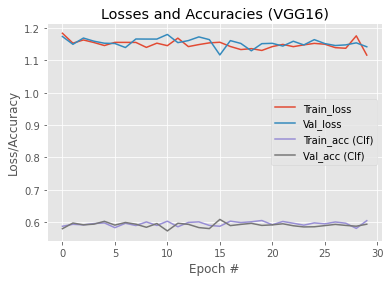

In [163]:
# Plotting Accuracy/Loss
N = np.arange(0, epochs)
plt.style.use('ggplot')
plt.figure()
plt.plot(N, M2.history['classification_output_loss'], label='Train_loss')
plt.plot(N, M2.history['val_classification_output_loss'], label='Val_loss')
plt.plot(N, M2.history['classification_output_accuracy'], label='Train_acc (Clf)')
plt.plot(N, M2.history['val_classification_output_accuracy'], label='Val_acc (Clf)')
plt.title('Losses and Accuracies (VGG16)')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

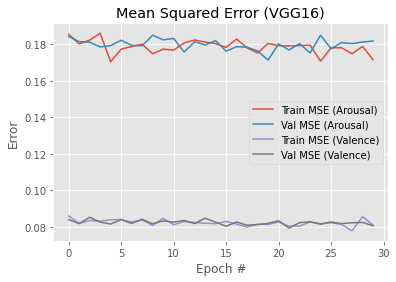

In [162]:
# Plotting MSE
plt.plot(N, M2.history['valence_output_mse'], label='Train MSE (Arousal)')
plt.plot(N, M2.history['val_valence_output_mse'], label='Val MSE (Arousal)')
plt.plot(N, M2.history['arousal_output_mse'], label='Train MSE (Valence)')
plt.plot(N, M2.history['val_arousal_output_mse'], label='Val MSE (Valence)')
plt.title('Mean Squared Error (VGG16)')
plt.xlabel('Epoch #')
plt.ylabel('Error')
plt.legend()
plt.show()

In [108]:
# Saving the model
model_VGG16_v2.save(os.path.join(DATASET_PATH_GDRIVE,'VGG16.h5'))

In [109]:
# Saving the model weights
model_VGG16_v2.save_weights(os.path.join(DATASET_PATH_GDRIVE,'VGG16_weights.h5'))

##Model Architecture <a name="img1"></a>

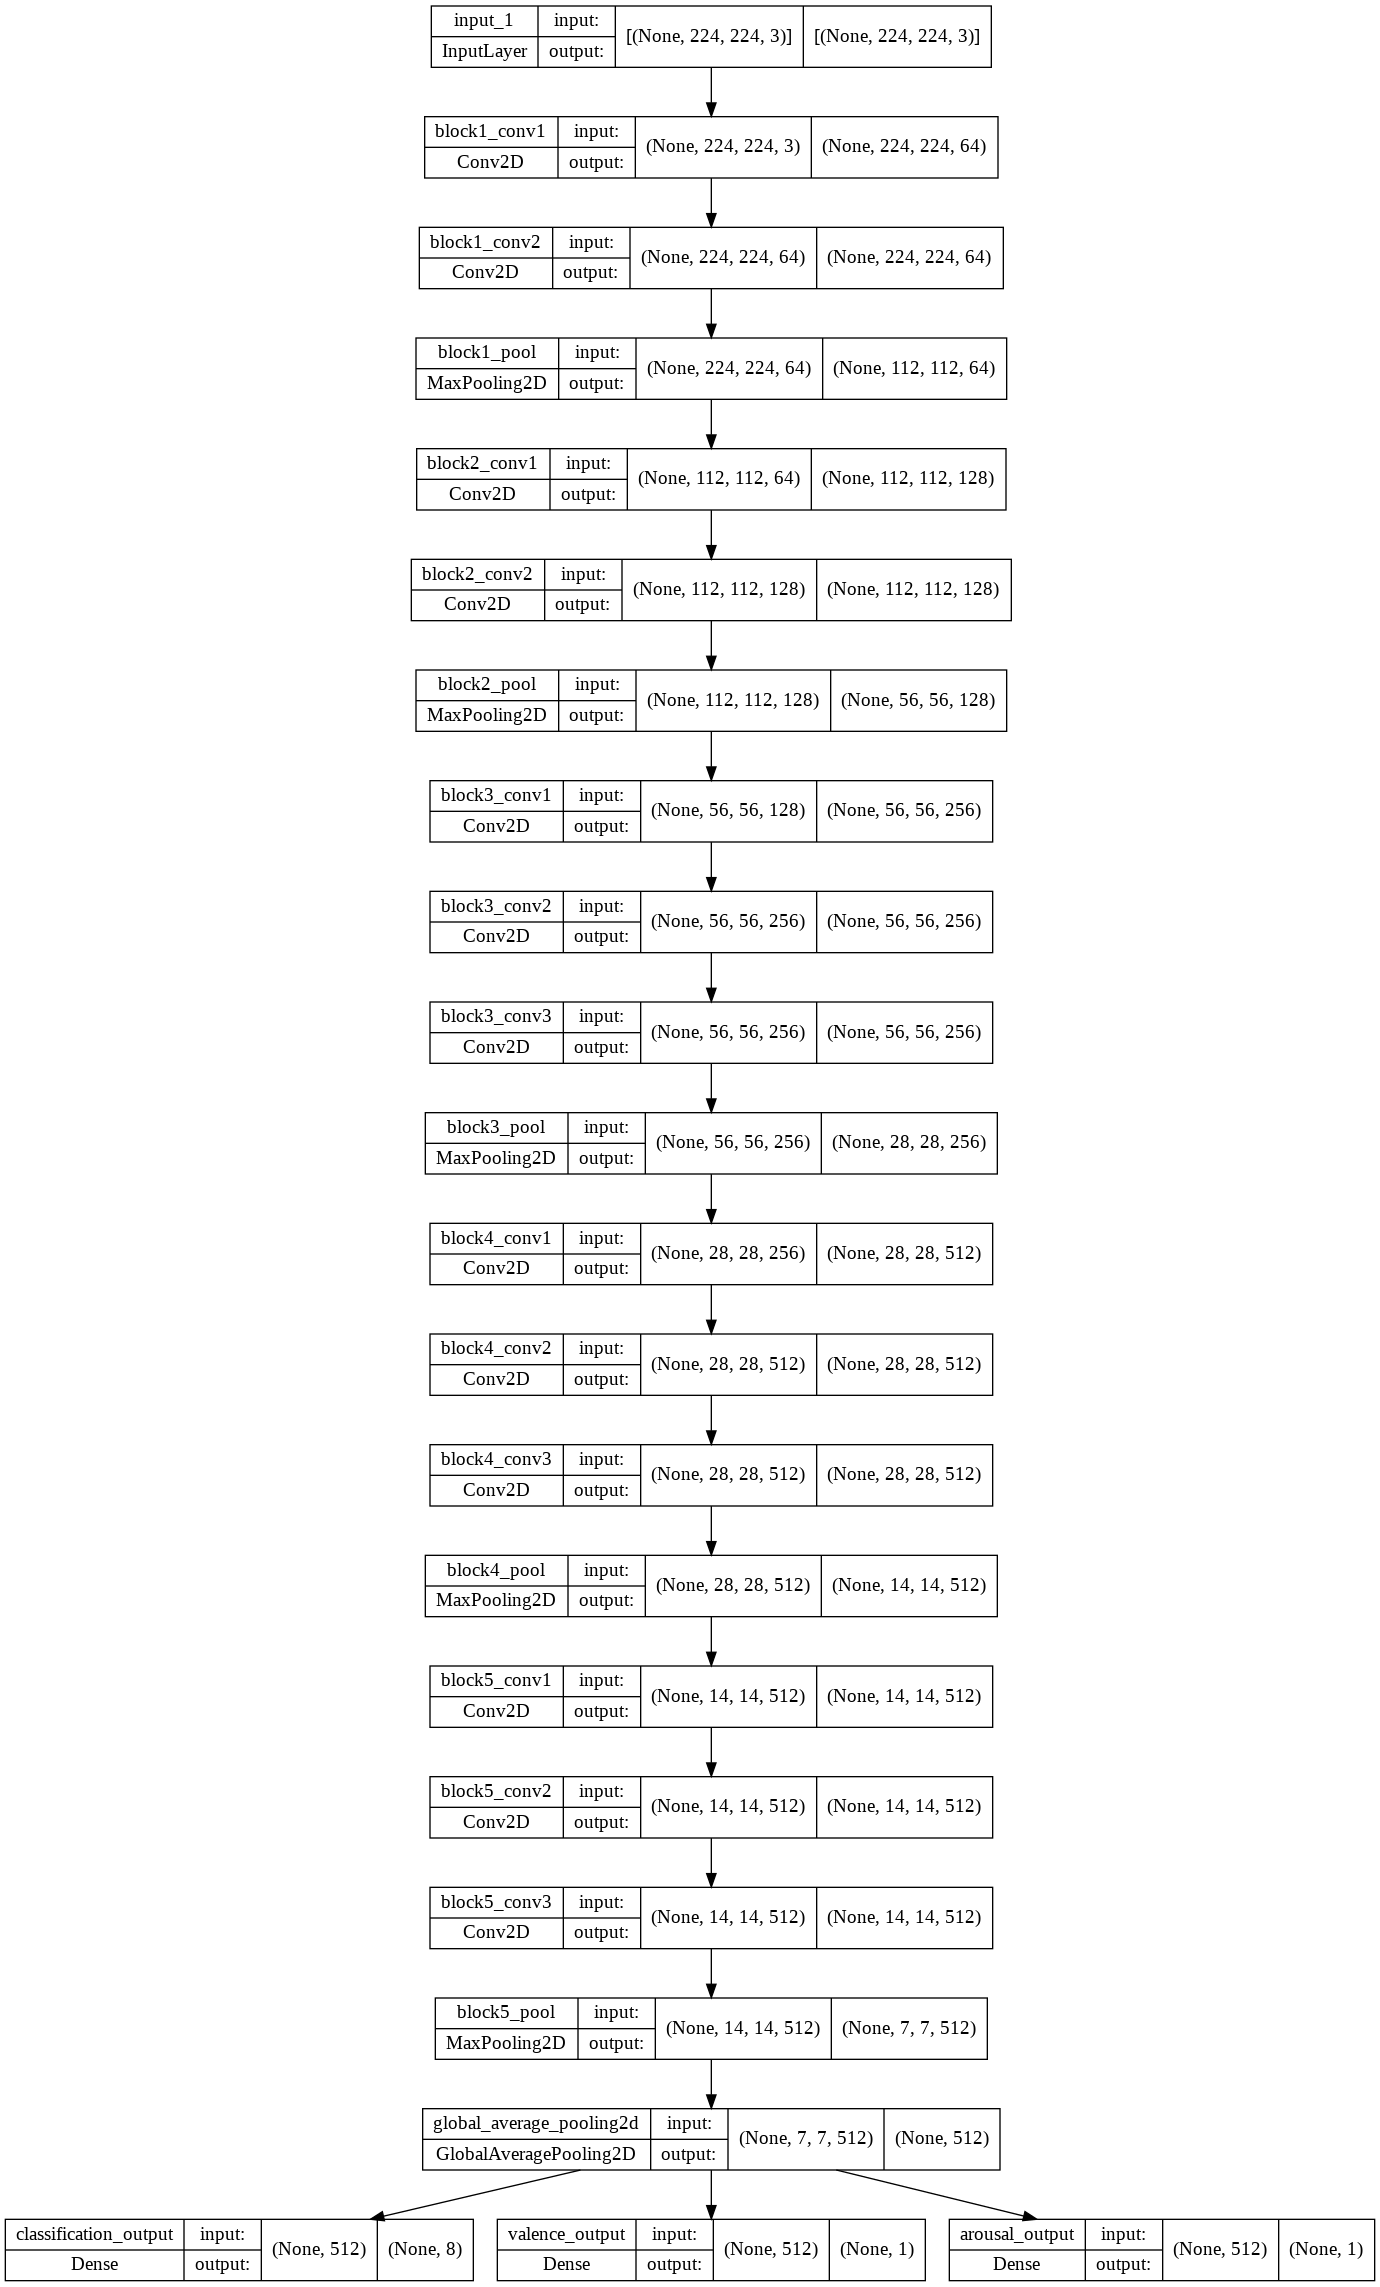

In [133]:
plot_model(model_VGG16_v2, "VGG16.png", show_shapes=True)

##ResNet50 <a name="ResNet"></a>

In [112]:
base_model = ResNet50(include_top=False, pooling='avg', weights='imagenet')

# Freeze the weights of the remaining layer
for layer in base_model.layers:
  layer.trainable = False

base_model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                          

In [120]:
# Output layer for 1 classification head (8 classes)
classifier = Dense(8, activation = 'softmax', name = 'classification_output')(base_model.output)

# Output layers for 2 regression heads (1 value each)
regressor_val = Dense(1,activation = 'linear', name = 'valence_output')(base_model.output)
regressor_aro = Dense(1,activation = 'linear',name = 'arousal_output')(base_model.output)

outputs = [classifier, regressor_val, regressor_aro]

# Compile the model for training
model_RESNET50_v1 = Model(base_model.input, outputs)


model_RESNET50_v1.compile(
    optimizer = Adam(learning_rate = 0.001),
    loss = {'classification_output' : 'sparse_categorical_crossentropy', 'valence_output' : 'mse', 'arousal_output' : 'mse'},
    metrics = {'classification_output': 'accuracy', 'valence_output' : 'mse', 'arousal_output' : 'mse'},
    loss_weights = [0.6, 0.2, 0.2])


In [121]:
# callbacks for checkpoint, learning rate reducer on plateau, and saving training logs into .csv

checkpoint = ModelCheckpoint(filepath= os.path.join(DATASET_PATH_GDRIVE,'RESNET50_FER_w1.h5'),
                             monitor='val_classification_output_accuracy',
                             verbose=1,
                             save_best_only=True)

lr_reducer = ReduceLROnPlateau(factor = 0.1,
                               cooldown = 0,
                               patience = 3,
                               min_lr = 0.5e-6)

csv_logger = CSVLogger(os.path.join(DATASET_PATH_GDRIVE,'train_logs_resnet.csv'))

callbacks = [checkpoint, lr_reducer, csv_logger]

In [122]:
M3 = model_RESNET50_v1.fit_generator(
    train_generator,
    steps_per_epoch = 100, # train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = 100, # validation_generator.samples // batch_size,
    epochs = epochs,
    callbacks = callbacks)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/30
100/100 [==============================] - ETA: 0s - loss: 1.0285 - classification_output_loss: 1.5103 - valence_output_loss: 0.3860 - arousal_output_loss: 0.2255 - classification_output_accuracy: 0.4484 - valence_output_mse: 0.3860 - arousal_output_mse: 0.2255
Epoch 1: val_classification_output_accuracy improved from -inf to 0.47406, saving model to /content/drive/MyDrive/ACV/Assignments/Asg2/RESNET50_FER_w1.h5
100/100 [==============================] - 112s 1s/step - loss: 1.0285 - classification_output_loss: 1.5103 - valence_output_loss: 0.3860 - arousal_output_loss: 0.2255 - classification_output_accuracy: 0.4484 - valence_output_mse: 0.3860 - arousal_output_mse: 0.2255 - val_loss: 0.9562 - val_classification_output_loss: 1.4723 - val_valence_output_loss: 0.2740 - val_arousal_output_loss: 0.0899 - val_classification_output_accuracy: 0.4741 - val_valence_output_mse: 0.2740 - val_arousal_output_mse: 0.0899 - lr: 0.0010
Epoch 2/30
100/100 [==============================] - 

##Plots <a name="plot2"></a>

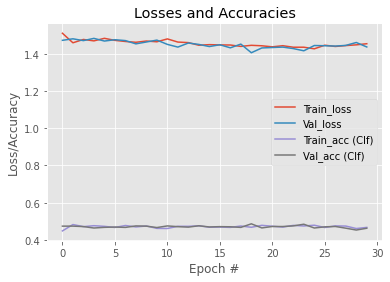

In [125]:
# Plotting Loos/Accuracy
N = np.arange(0, epochs)
plt.style.use('ggplot')
plt.figure()
plt.plot(N, M3.history['classification_output_loss'], label='Train_loss')
plt.plot(N, M3.history['val_classification_output_loss'], label='Val_loss')
plt.plot(N, M3.history['classification_output_accuracy'], label='Train_acc (Clf)')
plt.plot(N, M3.history['val_classification_output_accuracy'], label='Val_acc (Clf)')
plt.title('Losses and Accuracies (RESNET50)')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

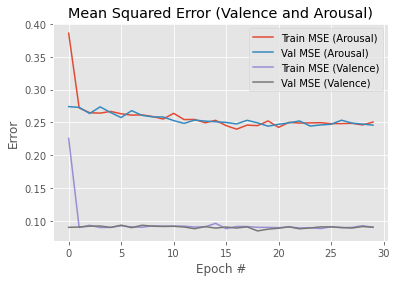

In [156]:
# Plotting MSE
plt.plot(N, M3.history['valence_output_mse'], label='Train MSE (Arousal)')
plt.plot(N, M3.history['val_valence_output_mse'], label='Val MSE (Arousal)')
plt.plot(N, M3.history['arousal_output_mse'], label='Train MSE (Valence)')
plt.plot(N, M3.history['val_arousal_output_mse'], label='Val MSE (Valence)')
plt.title('Mean Squared Error (RESNET50)')
plt.xlabel('Epoch #')
plt.ylabel('Error')
plt.legend()
plt.show()

In [ ]:
# resnet_logs = pd.read_csv(os.path.join(DATASET_PATH_GDRIVE,'train_logs_resnet.csv'))

Transfer Learning for Distinct Task

In [129]:
stem = None # layer that is the convolutional layer for the stem group
groups = [] # the add layer for each convolutional group
conv2d = [] # the convolutional layers of a group
first_conv2d = True
for layer in model_RESNET50_v1.layers:
  if type(layer) == Conv2D:
    # In ResNet50, the first Conv2D is the stem convolutional layer
    if first_conv2d == True:
      stem = layer
      first_conv2d = False
# Keep list of convolutional layers per convolutional group
    else:
      conv2d.append(layer)
# Each convolutional group in Residual Networks ends with a Add layer.
# Maintain list in reverse order (top-most conv group is top of list)
  elif type(layer) == Add:
    groups.insert(0, conv2d)
    conv2d = []
# Unfreeze a convolutional group at a time (from top-most to bottom-most)
# And fine-tune (train) that layer
for i in range(1, len(groups)):
# Unfreeze the convolutional layers in this conv/residual group
  for layer in groups[i]:
    layer.trainable = True
# re-compile the model for training
    model_RESNET50_v1.compile(
        optimizer = Adam(learning_rate = 0.001),
        loss = {'classification_output' : 'sparse_categorical_crossentropy', 'valence_output' : 'mse', 'arousal_output' : 'mse'},
        metrics = {'classification_output': 'accuracy', 'valence_output' : 'mse', 'arousal_output' : 'mse'},
        loss_weights = [0.6, 0.2, 0.2])

    model_RESNET50_v1.fit_generator(
        train_generator,
        steps_per_epoch = 100, # train_generator.samples // batch_size,
        validation_data = validation_generator, 
        validation_steps = 100, # validation_generator.samples // batch_size,
        epochs = 5,
        callbacks = callbacks)


Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


100/100 [==============================] - ETA: 0s - loss: 0.9557 - classification_output_loss: 1.4733 - valence_output_loss: 0.2634 - arousal_output_loss: 0.0953 - classification_output_accuracy: 0.4717 - valence_output_mse: 0.2634 - arousal_output_mse: 0.0953
Epoch 1: val_classification_output_accuracy did not improve from 0.48656
100/100 [==============================] - 146s 1s/step - loss: 0.9557 - classification_output_loss: 1.4733 - valence_output_loss: 0.2634 - arousal_output_loss: 0.0953 - classification_output_accuracy: 0.4717 - valence_output_mse: 0.2634 - arousal_output_mse: 0.0953 - val_loss: 0.9422 - val_classification_output_loss: 1.4541 - val_valence_output_loss: 0.2531 - val_arousal_output_loss: 0.0957 - val_classification_output_accuracy: 0.4652 - val_valence_output_mse: 0.2531 - val_arousal_output_mse: 0.0957 - lr: 0.0010
Epoch 2/5
100/100 [==============================] - ETA: 0s - loss: 0.9581 - classification_output_loss: 1.4755 - valence_output_loss: 0.2672 - a

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/5
100/100 [==============================] - ETA: 0s - loss: 0.9113 - classification_output_loss: 1.4057 - valence_output_loss: 0.2418 - arousal_output_loss: 0.0975 - classification_output_accuracy: 0.5020 - valence_output_mse: 0.2418 - arousal_output_mse: 0.0975
Epoch 1: val_classification_output_accuracy did not improve from 0.55641
100/100 [==============================] - 152s 1s/step - loss: 0.9113 - classification_output_loss: 1.4057 - valence_output_loss: 0.2418 - arousal_output_loss: 0.0975 - classification_output_accuracy: 0.5020 - valence_output_mse: 0.2418 - arousal_output_mse: 0.0975 - val_loss: 0.8819 - val_classification_output_loss: 1.3585 - val_valence_output_loss: 0.2433 - val_arousal_output_loss: 0.0905 - val_classification_output_accuracy: 0.5205 - val_valence_output_mse: 0.2433 - val_arousal_output_mse: 0.0905 - lr: 0.0010
Epoch 2/5
100/100 [==============================] - ETA: 0s - loss: 0.8488 - classification_output_loss: 1.3127 - valence_output_loss: 

KeyboardInterrupt: ignored

In [131]:
# Unfreeze the stem convolutional and do a final fine-tuning
stem.trainable = True

model_RESNET50_v1.compile(
    optimizer = Adam(learning_rate = 0.001),
    loss = {'classification_output' : 'sparse_categorical_crossentropy', 'valence_output' : 'mse', 'arousal_output' : 'mse'},
    metrics = {'classification_output': 'accuracy', 'valence_output' : 'mse', 'arousal_output' : 'mse'},
    loss_weights = [0.6, 0.2, 0.2])

m4 = model_RESNET50_v1.fit_generator(
    train_generator,
    steps_per_epoch = 100, # train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = 100, # validation_generator.samples // batch_size,
    epochs = 1,
    callbacks = callbacks)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  app.launch_new_instance()


100/100 [==============================] - ETA: 0s - loss: 0.8287 - classification_output_loss: 1.2838 - valence_output_loss: 0.1983 - arousal_output_loss: 0.0938 - classification_output_accuracy: 0.5537 - valence_output_mse: 0.1983 - arousal_output_mse: 0.0938
Epoch 1: val_classification_output_accuracy improved from 0.55641 to 0.56656, saving model to /content/drive/MyDrive/ACV/Assignments/Asg2/RESNET50_FER_w1.h5
100/100 [==============================] - 229s 2s/step - loss: 0.8287 - classification_output_loss: 1.2838 - valence_output_loss: 0.1983 - arousal_output_loss: 0.0938 - classification_output_accuracy: 0.5537 - valence_output_mse: 0.1983 - arousal_output_mse: 0.0938 - val_loss: 0.8093 - val_classification_output_loss: 1.2555 - val_valence_output_loss: 0.1887 - val_arousal_output_loss: 0.0913 - val_classification_output_accuracy: 0.5666 - val_valence_output_mse: 0.1887 - val_arousal_output_mse: 0.0913 - lr: 0.0010


In [134]:
# Saving the model
model_RESNET50_v1.save(os.path.join(DATASET_PATH_GDRIVE,'RESNET50.h5'))

In [135]:
# Saving the model weights
model_RESNET50_v1.save_weights(os.path.join(DATASET_PATH_GDRIVE,'RESNET50_weights.h5'))

## Model Architecture <a name="img2"></a>

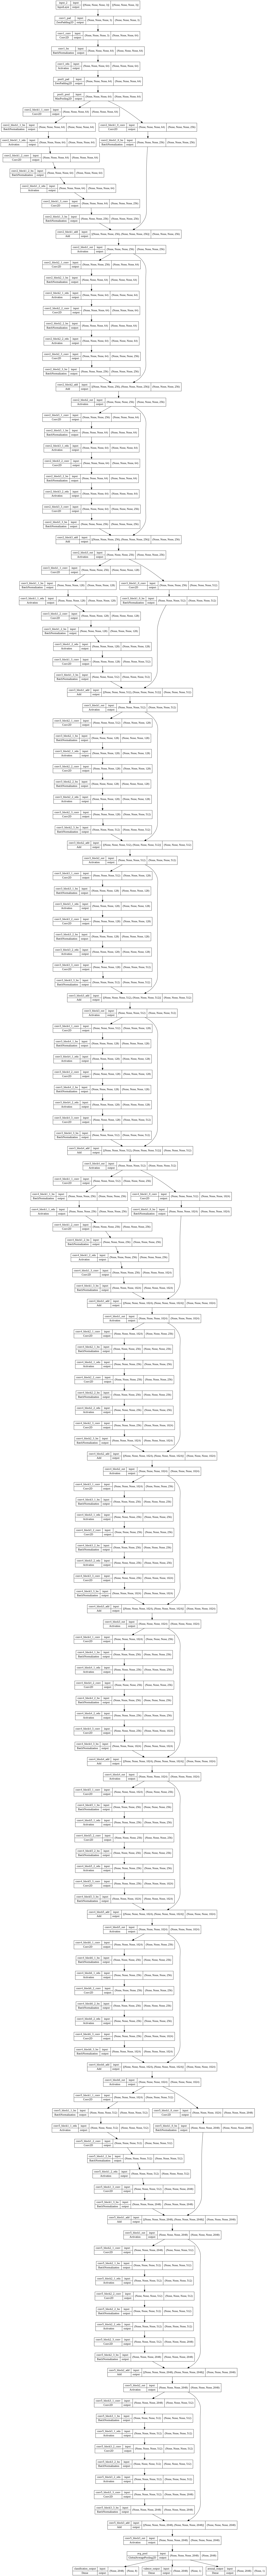

In [132]:
plot_model(model_RESNET50_v1, "RESNET50.png", show_shapes=True)

# Model Predictions <a name="Test"></a>

In [73]:
test_dir = os.path.join(DATASET_PATH_LOCAL,'test_set/images')

In [74]:
test_df

Image  Expression   Valence   Arousal
0        0.jpg           0 -0.176846 -0.077640
1        1.jpg           0 -0.367789  0.183895
2       10.jpg           7 -0.648471  0.658149
3      100.jpg           3  0.150794  0.666667
4     1001.jpg           0 -0.135501  0.004839
...        ...         ...       ...       ...
3994   992.jpg           5 -0.738095  0.436508
3995   994.jpg           1  0.468254  0.119048
3996   995.jpg           1  0.531746  0.015873
3997   996.jpg           6 -0.416183  0.701703
3998   999.jpg           3  0.176846  0.599551

[3999 rows x 4 columns]

In [75]:
# test_datagen = ImageDataGenerator(rescale=1./255)

# test_generator = test_datagen.flow_from_dataframe(
#     dataframe = test_df,
#     directory = test_dir,
#     x_col = 'Image',
#     y_col = None,
#     target_size = (img_height, img_width),
#     batch_size = batch_size,
#     class_mode = None,
#     shuffle = 'False')

Found 3999 validated image filenames.


In [ ]:
# # test_generator.reset()
# pred = model_VGG16_v2.predict_generator(test_generator,
#                                        steps = test_generator.samples // batch_size,
#                                        verbose=1)

##VGG16 <a name="vgg_predict"></a>

In [ ]:
# td = np.load('/content/dataset/testData.npy')
# print(td.shape)

(3999, 224, 224, 3)


In [ ]:
# model_VGG16_v2 = keras.models.load_model(os.path.join(DATASET_PATH_GDRIVE,'VGG16.h5'))

In [ ]:
pred = model_VGG16_v2.predict(testData, verbose= 1)

125/125 [==============================] - 2104s 17s/step


In [77]:
# pred = model_VGG16_v2.predict(testData)

In [78]:
print(type(pred))

<class 'list'>


In [80]:
print(pred[0][0])
print(pred[1][0])
print(pred[2][0])

[1.0000000e+00 0.0000000e+00 3.1834671e-29 2.2359611e-32 0.0000000e+00
 0.0000000e+00 2.3082990e-20 1.3125325e-28]
[-9.5866375]
[-7.9488125]


In [81]:
expPred , valPred , aroPred = pred

In [82]:
# Converting Predicted Expression list from 8 values to 1 by argmax
expPred = np.argmax(expPred, axis=1)
expPredicted = list(expPred)

print(len(expPredicted))
print(expPredicted[0:5])

3999
[0, 0, 0, 0, 0]


In [83]:
expTrue = test_df['Expression'].to_list()

print(len(expTrue))
print (expTrue[0:5])

3999
[0, 0, 7, 3, 0]


In [84]:
# Converting Predicted Arousal list to desired shape
aroPredicted = []

for i in range(len(aroPred)):
  aroPredTemp = aroPred[i][0]
  aroPredicted.append(aroPredTemp)

print(len(aroPredicted))
print (aroPredicted[0:5])

3999
[-7.9488125, -4.5834785, -2.7556305, -7.3458076, -5.2469864]


In [85]:
aroTrue = test_df['Arousal'].to_list()

print(len(aroTrue))
print (aroTrue[0:5])

3999
[-0.0776398, 0.183895, 0.658149, 0.666667, 0.00483933]


In [86]:
# Converting Predicted Valence list to desired shape
valPredicted = []

for i in range(len(valPred)):
  valPredTemp = valPred[i][0]
  valPredicted.append(valPredTemp)

print(len(valPredicted))
print (valPredicted[0:5])

3999
[-9.5866375, 3.3910818, 2.3921645, 6.1829762, 0.34561908]


In [155]:
valTrue = test_df['Valence'].to_list()

print(len(valTrue))
print (valTrue[0:5])

3999
[-0.176846, -0.367789, -0.648471, 0.150794, -0.135501]


## ResNet50 <a name="resnet_predict"></a>

In [ ]:
pred2 = model_RESNET50_v1.predict(testData, verbose=1)

125/125 [==============================] - 658s 5s/step


In [136]:
# pred2 = model_RESNET50_v1.predict(testData)

In [137]:
print(type(pred2))

<class 'list'>


In [138]:
print(pred2[0][0])
print(pred2[1][0])
print(pred2[2][0])

[1.97e-05 9.94e-01 7.38e-05 1.74e-03 1.82e-04 4.29e-05 4.04e-03 2.36e-06]
[0.04]
[-0.16]


In [89]:
expPred2 , valPred2 , aroPred2 = pred2

In [90]:
# Converting Predicted Expression list from 8 values to 1 by argmax
expPred2 = np.argmax(expPred2, axis=1)
expPredicted2 = list(expPred2)

print(len(expPredicted2))
print(expPredicted2[0:5])

3999
[1, 1, 1, 1, 1]


In [145]:
expTrue = test_df['Expression'].to_list()

print(len(expTrue))
print (expTrue[0:5])

3999
[0, 0, 7, 3, 0]


In [147]:
# Converting Predicted Arousal list to desired shape
aroPredicted2 = []

for i in range(len(aroPred2)):
  aroPredTemp = aroPred2[i][0]
  aroPredicted2.append(aroPredTemp)

print(len(aroPredicted2))
print (aroPredicted2[0:5])

3999
[-0.16363484, 0.08970273, 0.16137522, -0.9831321, -0.008235864]


In [148]:
aroTrue = test_df['Arousal'].to_list()

print(len(aroTrue))
print (aroTrue[0:5])

3999
[-0.0776398, 0.183895, 0.658149, 0.666667, 0.00483933]


In [149]:
# Converting Predicted Valence list to desired shape
valPredicted2 = []

for i in range(len(valPred2)):
  valPredTemp = valPred2[i][0]
  valPredicted2.append(valPredTemp)

print(len(valPredicted2))
print (valPredicted2[0:5])

3999
[0.04436513, -0.23827903, -1.2705706, -0.9021501, -0.63051736]


In [150]:
valTrue = test_df['Valence'].to_list()

print(len(valTrue))
print (valTrue[0:5])

3999
[-0.176846, -0.367789, -0.648471, 0.150794, -0.135501]


# Plotting Confusion Matrices and Computing Performance Metrics <a name="CFM"></a>

###VGG16 <a name="vgg_cfm"></a>

Plotting Confusion Matrices

Confusion Matrix without Normalization
[[437  31   0  19   0   0  13   0]
 [322 145   0  17   1   0  15   0]
 [375  62   0  28   1   0  34   0]
 [333  25   0 127   1   0  14   0]
 [307  23   0 133   2   0  35   0]
 [362  63   0  32   0   0  43   0]
 [356  47   0  33   0   0  64   0]
 [419  55   0   9   1   0  15   0]]
Normalized Confusion Matrix
[[0.87 0.06 0.   0.04 0.   0.   0.03 0.  ]
 [0.64 0.29 0.   0.03 0.   0.   0.03 0.  ]
 [0.75 0.12 0.   0.06 0.   0.   0.07 0.  ]
 [0.67 0.05 0.   0.25 0.   0.   0.03 0.  ]
 [0.61 0.05 0.   0.27 0.   0.   0.07 0.  ]
 [0.72 0.13 0.   0.06 0.   0.   0.09 0.  ]
 [0.71 0.09 0.   0.07 0.   0.   0.13 0.  ]
 [0.84 0.11 0.   0.02 0.   0.   0.03 0.  ]]


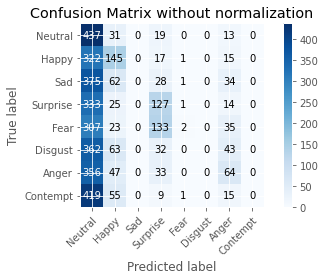

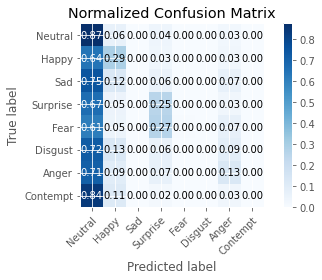

In [91]:
plotConfusions(expTrue, expPredicted)

Finding Metrics for Classification

In [97]:
findPerformanceMetrics(expTrue,expPredicted)

-----------------------
Accuracy Score:  0.194
Precision Score: 0.175
Recall Score:    0.194
F1 Score:        0.128
Cohens Kappa:    0.079
-----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finding Metrics for Regression

In [107]:
print('Valence')
findPerformanceMetrics2(np.array(valTrue),np.array(valPredicted))

print('Arousal')
findPerformanceMetrics2(np.array(aroTrue) , np.array(aroPredicted))

Valence
-----------------------
RMSE:       9.616
SAGR:       0.530
PCC / CORR: 0.093
CCC:        0.009
-----------------------
Arousal
-----------------------
RMSE:       6.036
SAGR:       0.370
PCC / CORR: 0.264
CCC:        0.027
-----------------------


###ResNet50 <a name="resnet_cfm"></a>

Plotting Confusion Matrics

Confusion Matrix without Normalization
[[  1 395  19  18   2   0  65   0]
 [  2 425  22  18   0   0  33   0]
 [  1 428  14  16   2   0  39   0]
 [  0 417  32   8   1   0  42   0]
 [  0 413  24  14   2   0  47   0]
 [  1 419  16  19   2   0  43   0]
 [  0 428  14  13   2   0  43   0]
 [  0 421  17  14   3   0  44   0]]
Normalized Confusion Matrix
[[0.   0.79 0.04 0.04 0.   0.   0.13 0.  ]
 [0.   0.85 0.04 0.04 0.   0.   0.07 0.  ]
 [0.   0.86 0.03 0.03 0.   0.   0.08 0.  ]
 [0.   0.83 0.06 0.02 0.   0.   0.08 0.  ]
 [0.   0.83 0.05 0.03 0.   0.   0.09 0.  ]
 [0.   0.84 0.03 0.04 0.   0.   0.09 0.  ]
 [0.   0.86 0.03 0.03 0.   0.   0.09 0.  ]
 [0.   0.84 0.03 0.03 0.01 0.   0.09 0.  ]]


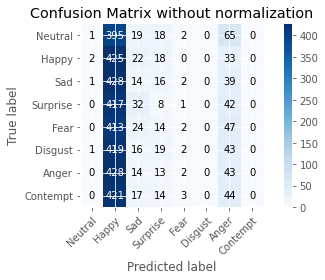

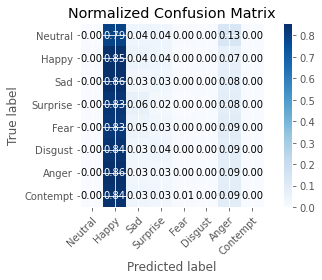

In [151]:
plotConfusions(expTrue, expPredicted2)

Finding Metrics for Classification

In [152]:
findPerformanceMetrics(expTrue,expPredicted2)

-----------------------
Accuracy Score:  0.123
Precision Score: 0.093
Recall Score:    0.123
F1 Score:        0.050
Cohens Kappa:    -0.002
-----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finding Metrics for Regression

In [153]:
print('Valence')
findPerformanceMetrics2(np.array(valTrue),np.array(valPredicted2))

print('Arousal')
findPerformanceMetrics2(np.array(aroTrue) , np.array(aroPredicted2))

Valence
-----------------------
RMSE:       0.946
SAGR:       0.652
PCC / CORR: 0.066
CCC:        0.045
-----------------------
Arousal
-----------------------
RMSE:       1.070
SAGR:       0.342
PCC / CORR: 0.015
CCC:        0.006
-----------------------


In [ ]:
  print("Area under ROC Curve:        %0.3f"% roc_auc_score(expTrue,expPredicted2, average='macro', multi_class='ovo'))

#Displaying Qualititative Results <a name="Qual"></a>

###VGG16 <a name="vgg_img"></a>

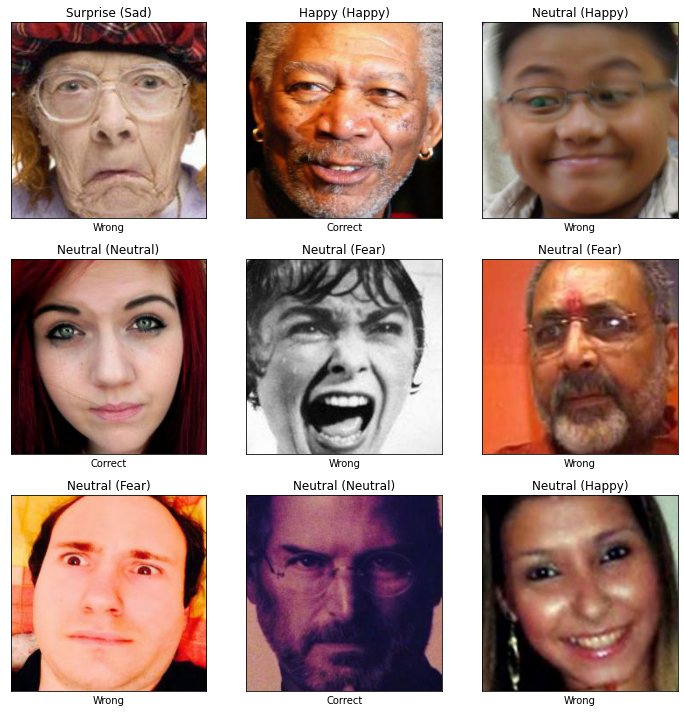

In [82]:
showImages(3,3,115,testData,expTrue,expPredicted)

###ResNet50 <a name="resnet_img"></a>

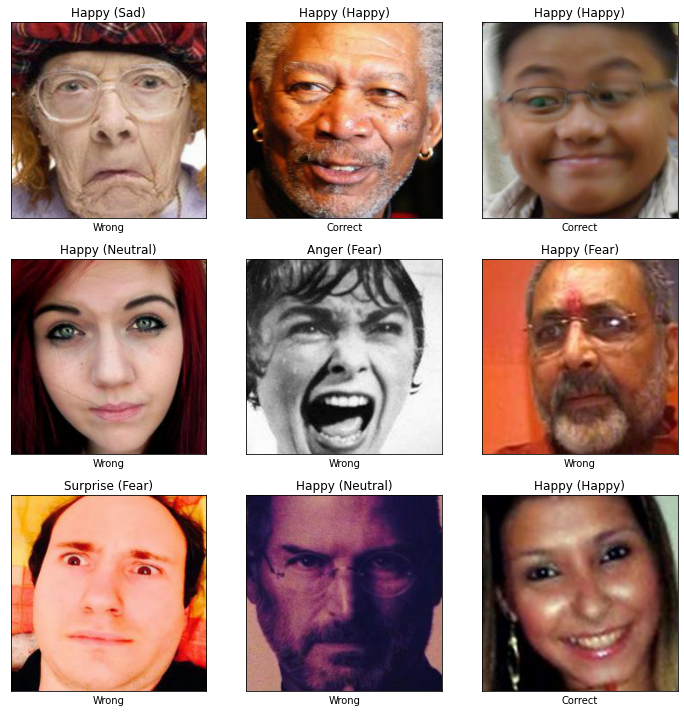

In [81]:
showImages(3,3,115,testData,expTrue,expPredicted2)